In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras as ks
print(tf.__version__)
import pandas as pd
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt

#plt.rcParams['figure.figsize'] = (12, 10)
#colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

from tensorflow import feature_column
from tensorflow.keras import layers
from tensorflow.keras import regularizers

from CleanUp import CleanUp, JobAnalysis

2.0.0


# Plotting Settings

In [11]:
from matplotlib.colors import LinearSegmentedColormap

P = {
    # Higher Education
    0: "#f1a340",
    1: "#998ec3",
    # B -> T and T -> T Categories
    "(-0.001, 0.2]": "#edf8fb",
    "(0.2, 0.4]": "#b3cde3",
    "(0.4, 0.6]": "#8c96c6",
    "(0.8, 1.0]": "#8856a7",
    "(0.6, 0.8]": "#810f7c", 
    # Employer / Recruiter
    "E": "#67a9cf",
    "R": "#ef8a62",
    "Employer": "#67a9cf",
    "Recruiter": "#ef8a62"
}

L = {
    '0': "Not Requested",
    '1': "Requested",
    # B -> T and T -> T Categories
    "(-0.001, 0.2]": "Very Low",
    "(0.2, 0.4]": "Low",
    "(0.4, 0.6]": "Moderate",
    "(0.8, 1.0]": "High",
    "(0.6, 0.8]": "Very High",  
    # Employer / Recruiter
    "E": "Employer",
    "R": "Recruiter"
}

def get_labels(ticklabels):
    labs = []
    for t in ticklabels:
        labs.append(L[t.get_text()])
        
    return labs

myColors = ((237,248,251, 1.0),
            (179,205,227, 1.0),
            (140,150,198, 1.0),
           (136,86,167, 1.0),
           (129,15,124, 1.0))
myColors = np.array(myColors)
myColors[:, :-1] /= 255.0
myColors = list(myColors)
cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))

In [362]:
j = JobAnalysis()

df.loc[:, "Clean Text"] = df["Text"].apply(clean_text)
df.loc[:, "Skills Match"] = df["Clean Text"].apply(j.skills_match)

# Main Insights

## Higher Education 
- Overall, the majority of entry level roles (around 66%) do not explicitly ask for applicants with a higher education.
- Recruiters are more likely to explcitly ask for higher education than employers directly.
- It appears that job listings which explcitly request for higher education applicants are less likely to offer above Moderate commercial experience to their successful candidates than those who do not explictly request higher education. 

## Skills Match
Overall, I personally have a skill profile which is matches most of the skills the employers/recruiters set out in their job listings.

- We see that there is no signicant difference in distributions in skills match by Higher Education. This suggests that higher education is used discriminatorily and presents a unneccessary barrier on those who could be qualified for the role. 

### Skills Match Bias
- It appears that overall the skills match bais is negatively skewed. This means that those who write the lsitings will typically underestimate the skills you have (and thus how qualified you are for the role), give the skills that also appear in the job listing.

## Commercial Experience from Roles
- We see that the vast majority of entry level job roles give a (very) low emphasis on how technology/data science-related skills are relevant to business objectives (which is an indicator of commercial experience). Therefore, we can expect that the majority of these roles provide very little in the way of commercial experience and thus preventing successful applicants / employees to gain the 'necessary' skill of commercial experience.
- We can also see a vague pattern that the greater the proportion of B-> T relation in the job listing, the overall lower the T -> T relation. This suggests that, assuming these realtions are mutually exclusive, the more engrained one is into the business, there is a lack of focus in using data science tools to solve business problems. Therefore, it further shows a trend that businesses not observing benefits of including data scientist into business decision-making.
- When we look at B -> T relations over higher education, there is very minimal differences between the distribution over y and n higher education. The heatmap plot makes it clearer though that jobs which set a lower education barrier to entry have a marginally greater proprotion of job listings which have moderate + B -> T relations

## B -> T Relations
- Overall, B -> T relation proportion is below Moderate (90th percentile = 0.433). To make this point clear, around 10% job listings from the sample appear to give the successful candidate moderate + commercial experience. This equates to approx 25 people who will be given this experience, and overall in the UK job market, 250 individuals. 
- The distribution of B -> T relation strength is similar between Employers and Recruiters, with job listings from Recruiters having a marginally higher B -> T relation strength than Employers. However, this is not significant. 
- The pointplot shows that job listings for recruiters almost constitently provide job listings which retain a higher business application (B -> T) as the emphasis on technology, data-science skills increases.
- However, there is noticeable variation in B -> T strength betweem Employers and Recruiters over Job Titles. This even gives a picture of which job roles might give a successful candidate moderate + Commercial Experience. <br> For example, we see that Machine Learning Engineer listings have on average a higher business application (B -> T strength) than Data Scientist job listings.  


# Structure of Data

In [4]:
# Loading datasets

# Dataset containing high B -> T proportions (B -> T > 0.4)
high_bt = pd.read_csv("high_bt.csv", index_col = 0)
# Dataset containing low B -> T proportions (B -> T < 0.4)
low_bt = pd.read_csv("low_bt.csv", index_col= 0, engine = "python")

all_bt = pd.concat([low_bt, high_bt])

all_bt.columns

Index(['Filename', 'Role', 'Seniority Level', 'Employer/Recruiter', 'Company',
       'Industry', 'Skills Match', 'Link', 'Word Count_x', 'Text', 'Masters',
       'PhD', 'Higher Education', 'none', 'bt', 'tt', 'Clean Text', 'bt_cats',
       'skills_cats', 'tt_cats'],
      dtype='object')

In [8]:
data_log = pd.read_csv("Data Log.csv", usecols = ["Filename", "Skills Match"])
all_bt = pd.merge(left = all_bt, right = data_log, on = "Filename")

# Skills Match_y represents LinkedIn skills match ratio
# Skills Match_x represents JLC skills match ratio
all_bt.loc[:,"Skills Match Deviation"] = all_bt["Skills Match_y"] - all_bt["Skills Match_x"]
all_bt.loc[:,"Skills Match Deviation cats"] = pd.cut(
    all_bt["Skills Match Deviation"].astype(float), [-1,-0.5,-0.25,0,0.25,0.5,1], include_lowest = True
)


,Filename,Skills Match
0,desc1,0.80
1,desc2,0.25
2,desc3,0.60
3,desc4,0.30
4,desc5,NaN


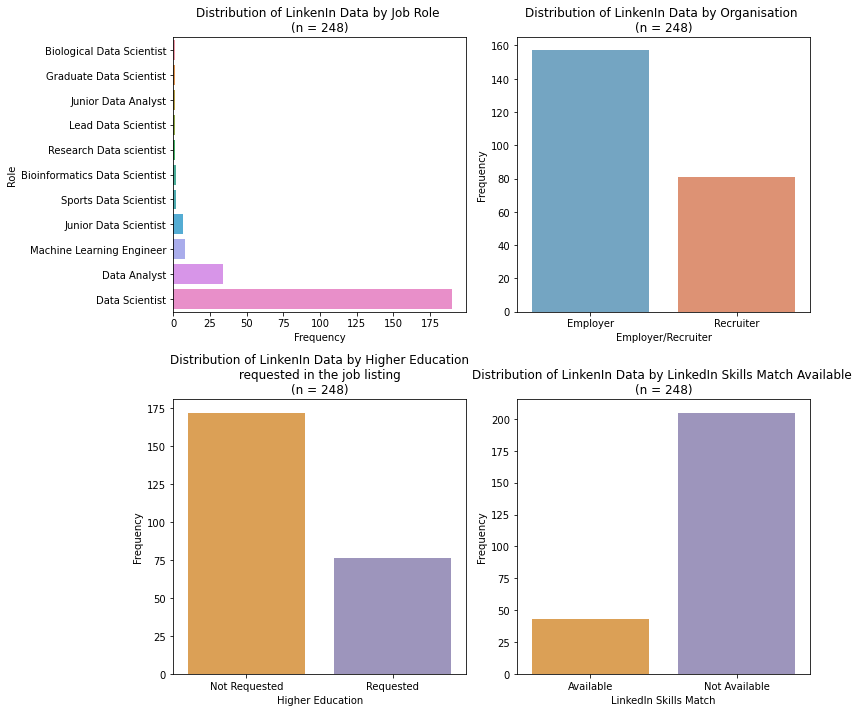

In [708]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)

c = all_bt.groupby("Role").size().reset_index().sort_values(0)
sns.barplot(x = 0, y = "Role", data = c, ax = ax1)
ax1.set_title("Distribution of LinkenIn Data by Job Role \n(n = {})".format(len(all_bt)))
ax1.set_xlabel("Frequency")
ax1

sns.countplot(all_bt["Employer/Recruiter"], palette = P, ax = ax2)
ax2.set_xticklabels(get_labels(ax2.get_xticklabels()))
ax2.set_title("Distribution of LinkenIn Data by Organisation \n(n = {})".format(len(all_bt)))
ax2.set_ylabel("Frequency")

sns.countplot(entry["Higher Education"], palette = P, ax = ax3)
ax3.set_xticklabels(get_labels(ax3.get_xticklabels()))
ax3.set_ylabel("Frequency")
ax3.set_title("Distribution of LinkenIn Data by Higher Education\n requested in the job listing \n(n = {})".format(len(all_bt)))

c = all_bt.loc[:,["Filename","Skills Match_y"]]
c.loc[:,"LinkedIn Skills Match"] = c["Skills Match_y"].isna().values.astype(int)
sns.countplot(c["LinkedIn Skills Match"], palette = P, ax = ax4)
ax4.set_xticklabels(["Available", "Not Available"])
ax4.set_title("Distribution of LinkenIn Data by LinkedIn Skills Match Available \n(n = {})".format(len(all_bt)))
ax4.set_ylabel("Frequency")


plt.tight_layout()


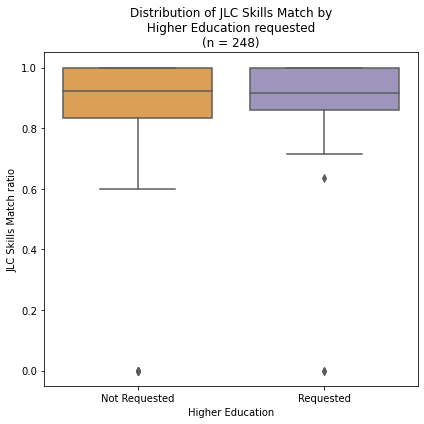

In [722]:
plt.figure(figsize = (6, 6))

ax2 = sns.boxplot(x = "Higher Education", y = "Skills Match", data = entry, palette = P)
ax2.set_xticklabels(get_labels(ax2.get_xticklabels()))
ax2.set_ylabel("JLC Skills Match ratio")
ax2.set_title("""Distribution of JLC Skills Match by\n Higher Education requested \n(n = {})""".format(all_bt.shape[0]))
plt.tight_layout()


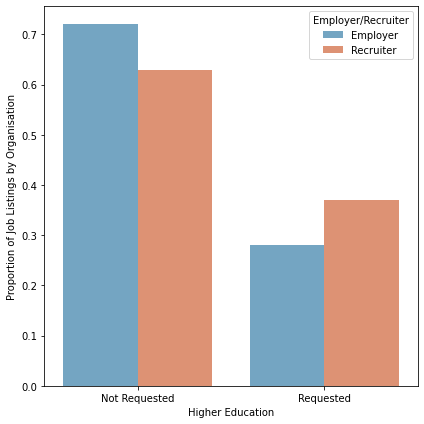

In [738]:
plt.figure(figsize = (6, 6))

c = all_bt.groupby(["Higher Education", "Employer/Recruiter"]).size()
c = (c/c.groupby(level=1).sum()).reset_index()
c["Employer/Recruiter"] = c["Employer/Recruiter"].map(L)

ax = sns.barplot(x = "Higher Education", y = 0, hue = "Employer/Recruiter", data = c, palette = P)
ax.set_xticklabels(get_labels(ax.get_xticklabels()))
ax.set_ylabel("Proportion of Job Listings by Organisation")

plt.tight_layout()


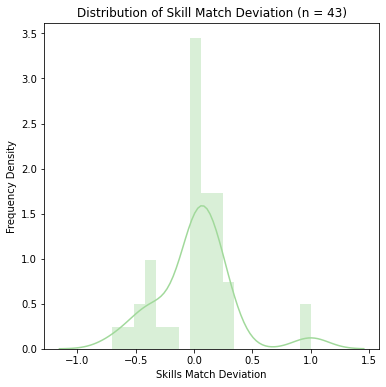

In [13]:
plt.figure(figsize = (6, 6))
sns.distplot(all_bt.loc[:,"Skills Match Deviation"], color = "#a1d99b")
plt.ylabel("Frequency Density")
plt.title("Distribution of Skill Match Deviation (n = {})".format(all_bt[~all_bt["Skills Match Deviation"].isna()].shape[0]))


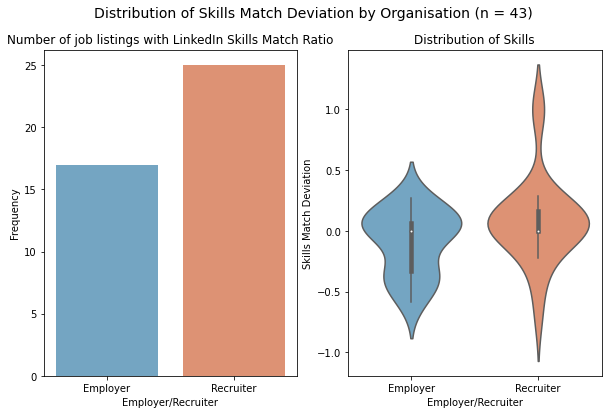

In [25]:
c = all_bt[~all_bt["Skills Match Deviation"].isna()]

f, (ax1, ax2) = plt.subplots(1,2, figsize = (10,6))

sns.countplot(c["Employer/Recruiter"], ax = ax1, palette = P)
ax1.set_xticklabels(get_labels(ax1.get_xticklabels()))
ax1.set_ylabel("Frequency")
ax1.set_title("Number of job listings with LinkedIn Skills Match Ratio")


sns.violinplot(x = "Employer/Recruiter",y = "Skills Match Deviation", data = c, ax = ax2, palette = P)
ax2.set_xticklabels(get_labels(ax2.get_xticklabels()))
ax2.set_title("Distribution of Skills")
#plt.tight_layout()

f.suptitle("Distribution of Skills Match Deviation by Organisation (n = {})".format(c.shape[0]), fontsize = 14)


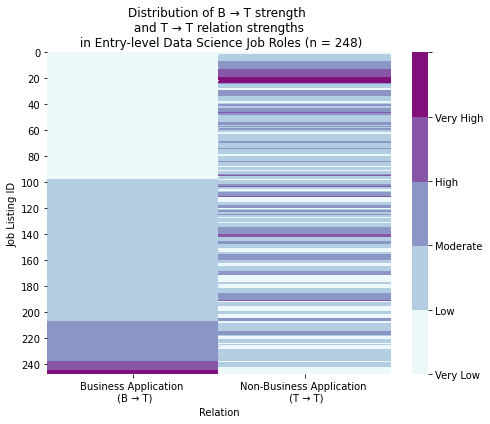

In [40]:
plt.figure(figsize = (7,6))
plt.title("Distribution of B → T strength \n and T → T relation strengths \n in Entry-level Data Science Job Roles (n = {})".format(len(all_bt)))

ax = sns.heatmap(all_bt.loc[:,"bt":"tt"].sort_values(["bt", "tt"]).values, cmap = cmap) #"viridis")
plt.xticks([0.5,1.5],["Business Application \n (B → T)", "Non-Business Application \n (T → T)"])
plt.xlabel("Relation")
plt.ylabel("Job Listing ID")
plt.yticks(np.arange(0, all_bt.shape[0],20), np.arange(0, all_bt.shape[0],20))


colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0, 0.2, 0.4 , 0.6 ,0.8 , 1.0])
colorbar.set_ticklabels(['Very Low', 'Low', 'Moderate', 'High', 'Very High'])
plt.tight_layout()


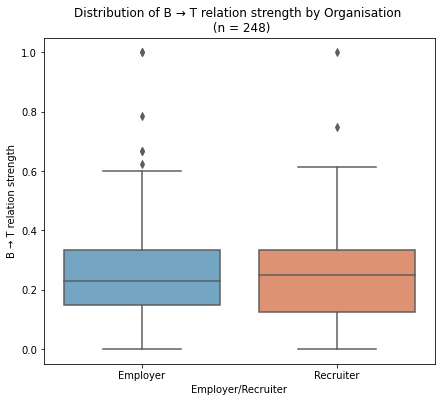

In [45]:
plt.figure(figsize = (7,6))
ax1 = sns.boxplot(x = "Employer/Recruiter", y = "bt", data = all_bt, palette = P)
ax1.set_xticklabels(get_labels(ax1.get_xticklabels()))
ax1.set_ylabel("B → T relation strength")
ax1.set_title("Distribution of B → T relation strength by Organisation \n (n = {})".format(all_bt.shape[0]))

In [63]:
freq_comps = all_bt["Company"].value_counts().reset_index()
freq_comps = freq_comps[freq_comps["Company"] > 1]["index"].values
freq_comps = all_bt[all_bt["Company"].isin(freq_comps)]
print(freq_comps.shape)

freq_comps["Company"] = pd.Categorical(freq_comps["Company"])
freq_comps = freq_comps.groupby("Company").mean().reset_index().sort_values("bt", ascending = False)
freq_comps = pd.merge(left = freq_comps, right = all_bt.loc[:,["Company", "Employer/Recruiter"]], on = "Company", how = "inner")
freq_comps = freq_comps[(freq_comps["bt"] > 0) & (~freq_comps["bt"].isna())]


(64, 23)


/Users/alexshepherd/miniconda3/envs/cogsci/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


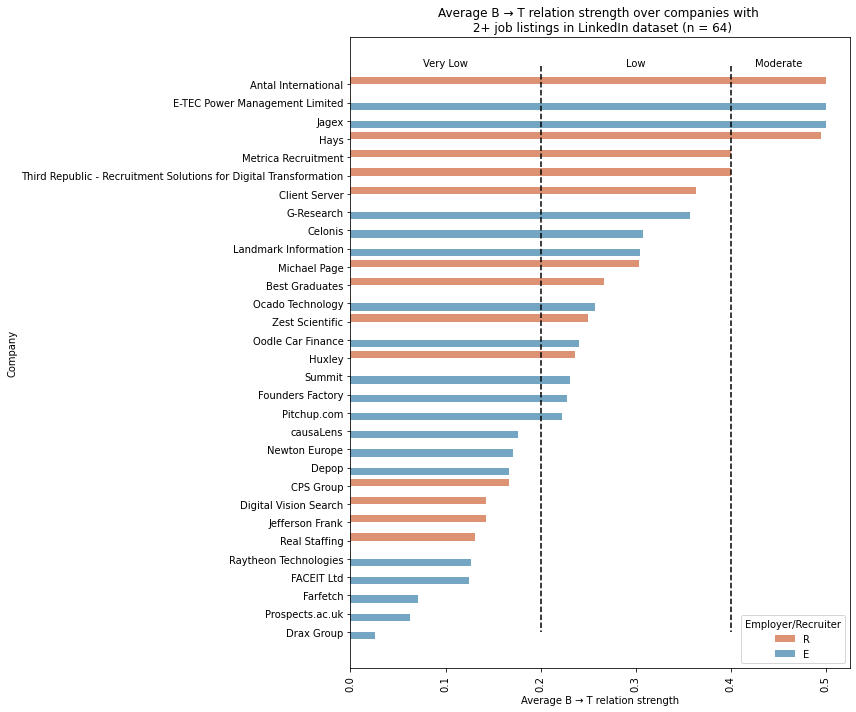

In [67]:

sns.barplot(y = "Company", x = "bt", hue = "Employer/Recruiter", data = freq_comps, orient = "h", palette = P)
plt.xticks(rotation = 90)
plt.xlabel("Average B → T relation strength")
plt.vlines(0.4, ymin = -1, ymax = 30, linestyles = "dashed")
plt.vlines(0.2, ymin = -1, ymax = 30, linestyles = "dashed")
plt.annotate("Very Low", (0.1,-1), ha='center')
plt.annotate("Low", (0.3,-1), ha='center')
plt.annotate("Moderate", (0.45,-1), ha='center')
plt.title("Average B → T relation strength over companies with \n 2+ job listings in LinkedIn dataset (n = 64)")
plt.tight_layout()


# Further Analysis

This section can be used for you to further analyse the dataset. This section also contains additional analysis which have been omitted from the LinkedIn article.

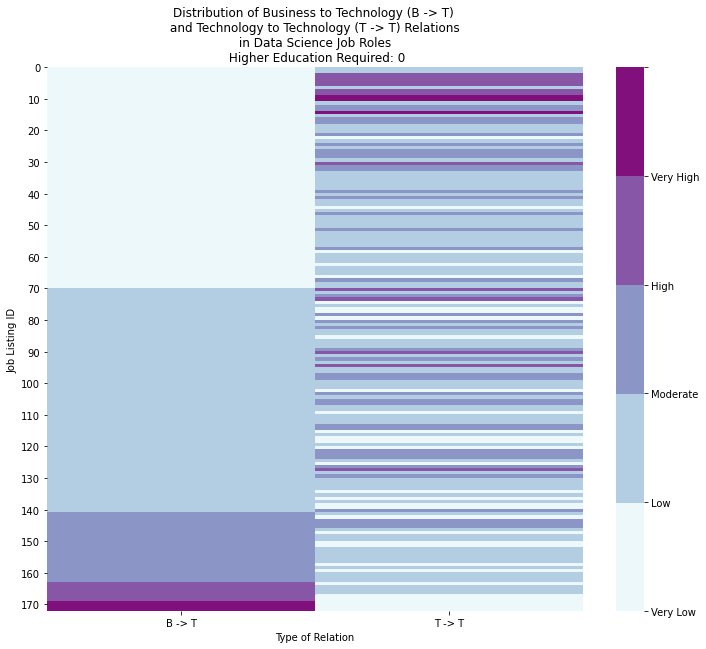

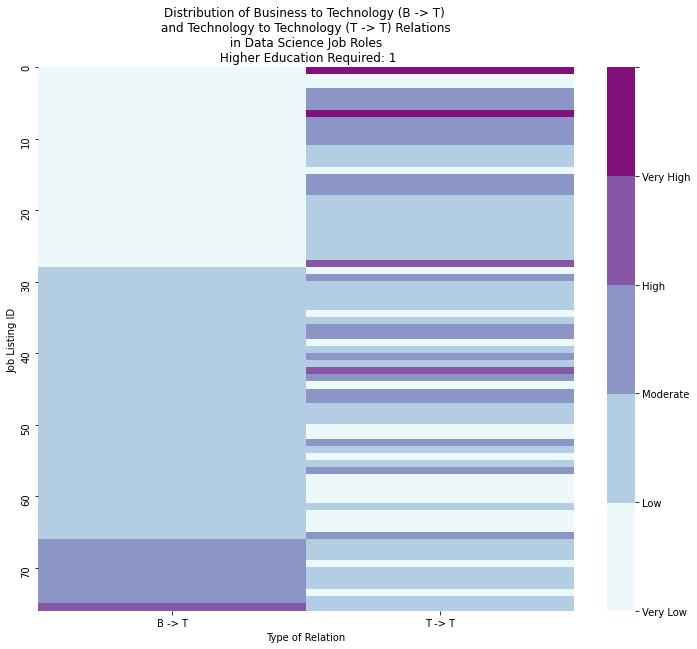

In [404]:
for c in all_bt["Higher Education"].unique():
    
    _ = all_bt[all_bt["Higher Education"] == c]

    plt.title("Distribution of Business to Technology (B -> T) \n and Technology to Technology (T -> T) Relations \n in Data Science Job Roles \n Higher Education Required: {}".format(c))

    ax = sns.heatmap(_.loc[:,"bt":"tt"].sort_values("bt").values, cmap = cmap) #"viridis")
    plt.xticks([0.5,1.5],["B -> T", "T -> T"])
    plt.xlabel("Type of Relation")
    plt.ylabel("Job Listing ID")
    plt.yticks(np.arange(0, _.shape[0],10), np.arange(0, _.shape[0],10))


    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([0, 0.2, 0.4 , 0.6 ,0.8 , 1.0])
    colorbar.set_ticklabels(['Very Low', 'Low', 'Moderate', 'High', 'Very High'])
    plt.show()

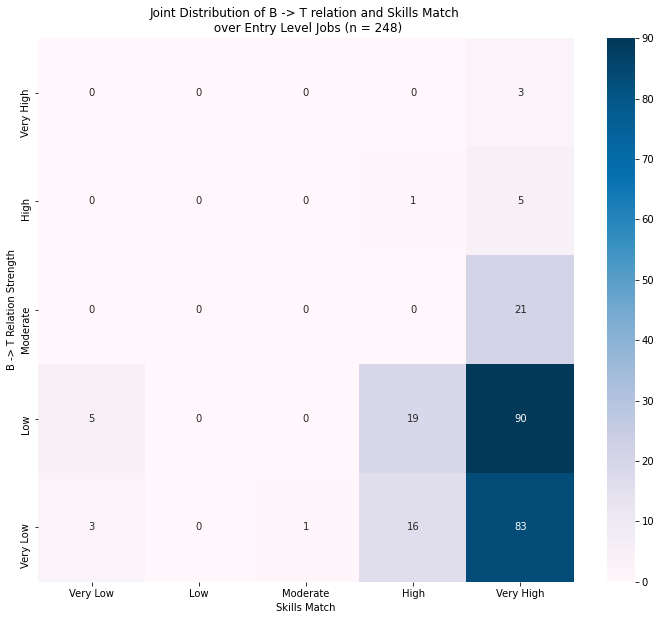

In [429]:
try:
    _ = bt_skills_cats.iloc[:25, -1].values.reshape((5,5))

    plt.title("Joint Distribution of B -> T relation and Skills Match \n over Entry Level Jobs (n = {})".format(entry.shape[0]))
    sns.heatmap(np.flip(_, 0), cmap = "PuBu", annot = True)
    plt.xlabel("Skills Match")
    plt.ylabel("B -> T Relation Strength")
    plt.xticks([0.5, 1.5, 2.5, 3.5, 4.5], cat_labs)
    plt.yticks([4.5, 3.5, 2.5, 1.5, 0.5], cat_labs)
    plt.show()

except:
    pass

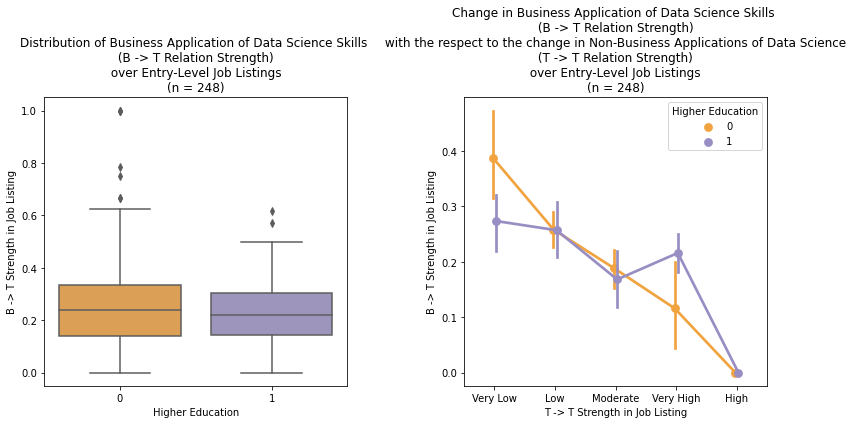

In [673]:
f, (ax1, ax2) = plt.subplots(1,2, figsize = (12, 6))

sns.boxplot(x = "Higher Education", y = "bt", data = entry, palette = P, ax = ax1)
ax1.set_ylabel("B -> T Strength in Job Listing")
ax1.set_title("""Distribution of Business Application of Data Science Skills \n (B -> T Relation Strength) \n over Entry-Level Job Listings \n(n = {})""".format(all_bt.shape[0]))



sns.pointplot(x = "tt_cats", y = "bt", hue = "Higher Education", data = entry, dodge=True, ax = ax2, palette = P)
ax2.set_ylabel("B -> T Strength in Job Listing")
ax2.set_xlabel("T -> T Strength in Job Listing")
ax2.set_xticklabels(get_labels(ax2.get_xticklabels()))
ax2.set_title("""Change in Business Application of Data Science Skills \n (B -> T Relation Strength) \n with the respect to the change in Non-Business Applications of Data Science \n (T -> T Relation Strength) \n over Entry-Level Job Listings \n(n = {})""".format(all_bt.shape[0]))

plt.tight_layout()

In [5]:
sns.boxplot(x = 'Role', y = "bt", data = all_bt)
plt.xticks(rotation = 45)

NameError: name 'all_bt' is not defined

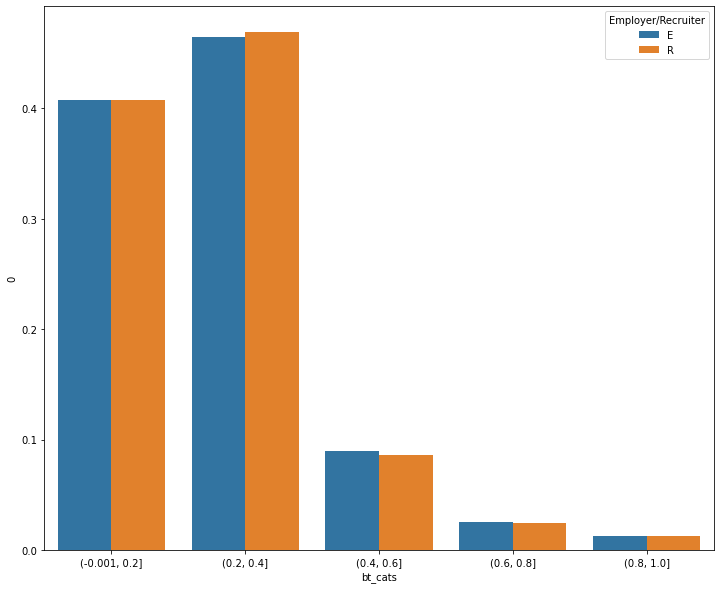

In [547]:
c = all_bt.groupby(["bt_cats", "Employer/Recruiter"]).size()
c = (c/c.groupby(level = 1).sum()).reset_index()

sns.barplot(x = "bt_cats", y = 0, hue = "Employer/Recruiter", data = c, palette = P)

(0.0, 1.0)

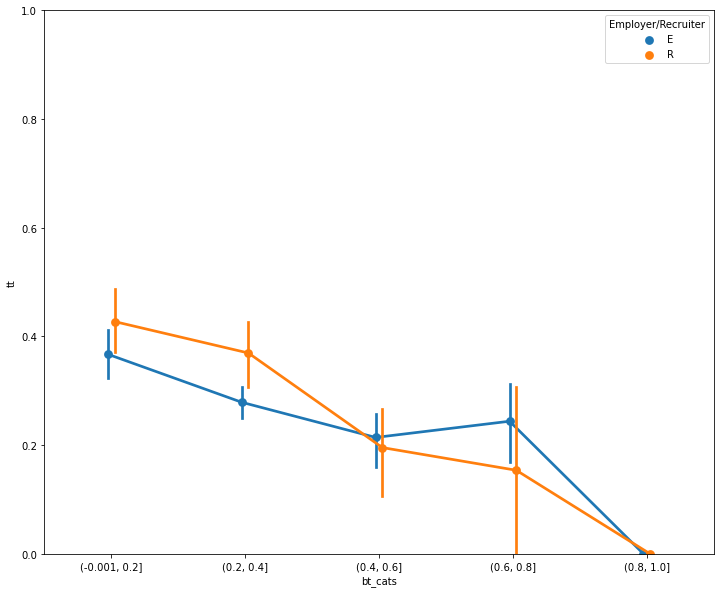

In [557]:
all_bt.loc[:, "bt_cats"] = pd.cut(all_bt["bt"].astype(float), [0,0.2,0.4,0.6,0.8,1], include_lowest = True)
all_bt.loc[:, "tt_cats"] = pd.cut(all_bt["tt"].astype(float), [0,0.2,0.4,0.6,0.8,1], include_lowest = True)


sns.pointplot(x = "bt_cats", y = "tt", data = all_bt, hue = "Employer/Recruiter", dodge=True, palette = P)
plt.ylim([0,1])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text major ticklabel objects>)

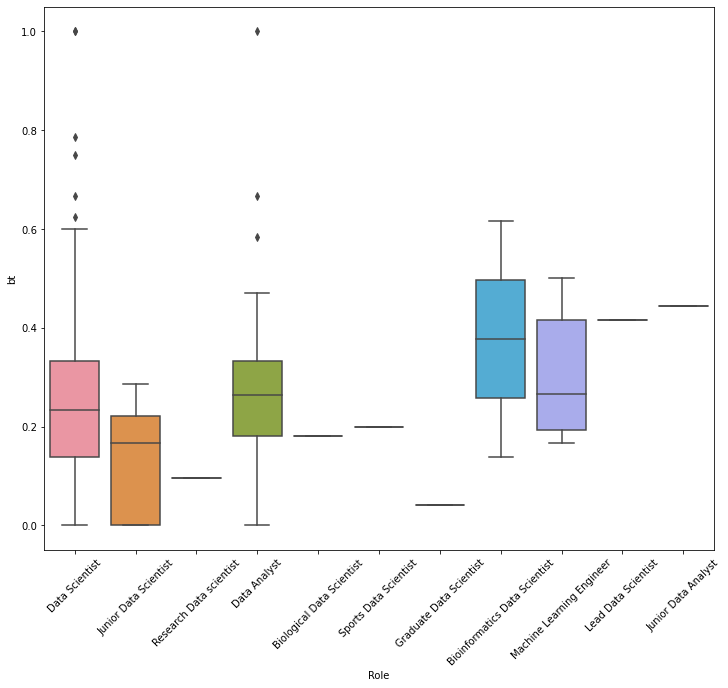

In [559]:
sns.boxplot(x = 'Role', y = "bt", data = all_bt) #hue = "Employer/Recruiter"
plt.xticks(rotation = 45)